# Check Fugues 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from dataset.utils import load_pickle_data, save_dict
from dataset.analyse import get_track_notes_nbr, get_track_length, get_track_extreme_pitch, non_binary_notes

In [2]:
DATA_FILE = os.path.join("Fugues_data", "data_48.pkl")

In [3]:
data = load_pickle_data(DATA_FILE)

In [4]:
print(len([0 for _ in data.keys()]))

105


## First look of the dataset

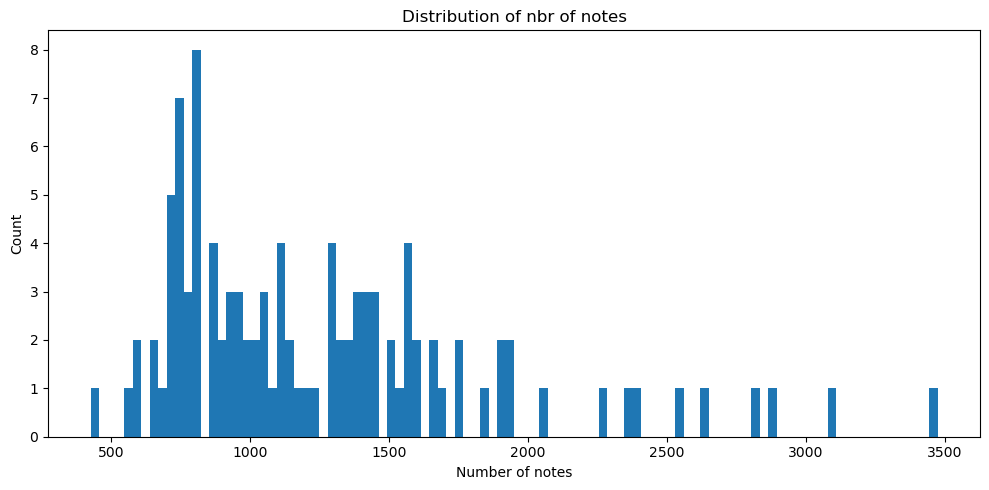

In [4]:
tracks_notes_nbr = list()

for track in data.values():
    tracks_notes_nbr.append(get_track_notes_nbr({"" : track})[""]) #trick because function for multi instruments.

plt.figure(figsize=(10,5))
plt.hist(tracks_notes_nbr, bins=100)
plt.title(f"Distribution of nbr of notes")
plt.xlabel("Number of notes")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

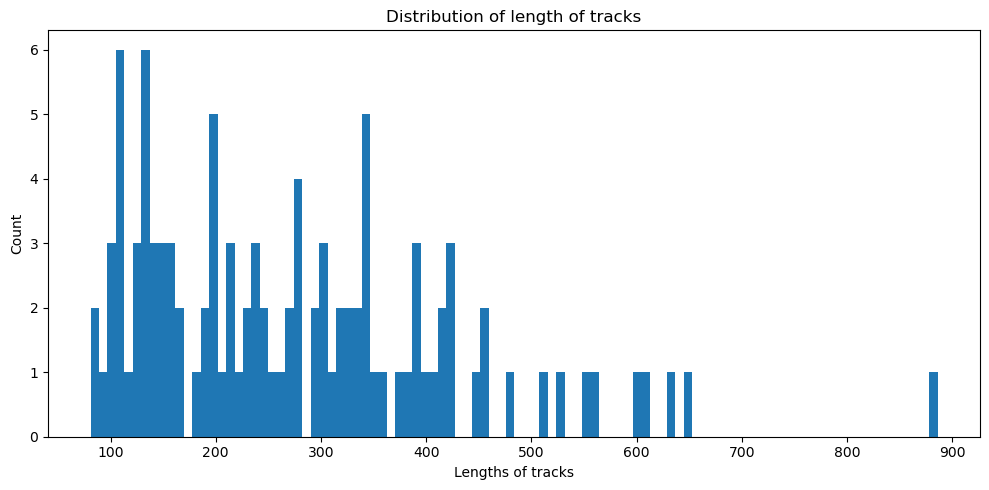

Minimum track lengths: 81.0
Maximum track lengths: 886.0


In [5]:
tracks_lengths = dict()

for name, track in data.items():
    tracks_lengths[name] = float(get_track_length({"" : track})[""]) #trick because function for multi instruments.

plt.figure(figsize=(10,5))
plt.hist(tracks_lengths.values(), bins=100)
plt.title(f"Distribution of length of tracks")
plt.xlabel("Lengths of tracks")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Minimum track lengths: {min(tracks_lengths.values())}")
print(f"Maximum track lengths: {max(tracks_lengths.values())}")

In [6]:
tracks_to_remove = sorted(tracks_lengths, key=tracks_lengths.get)[-9:]

print(tracks_to_remove)

datafilterd = data.copy()

for key in tracks_to_remove:
    try:
        del datafilterd[key]
    except Exception as e:
        print(e)

print(f"New maximum track length: {max([elem for name, elem in tracks_lengths.items() if name not in tracks_to_remove])}")

['op87_04b', 'op87_10b', 'op87_20b', 'op87_23b', 'BWV_0891', 'op87_12b', 'BWV_0944', 'op87_21b', 'op87_24b']
New maximum track length: 481.0


op87_24b is very long and we must have uniform size at the end, it will slow a lot the training so we may remove it.

Removing the 9 last ones may reduce the image size per almost 2.

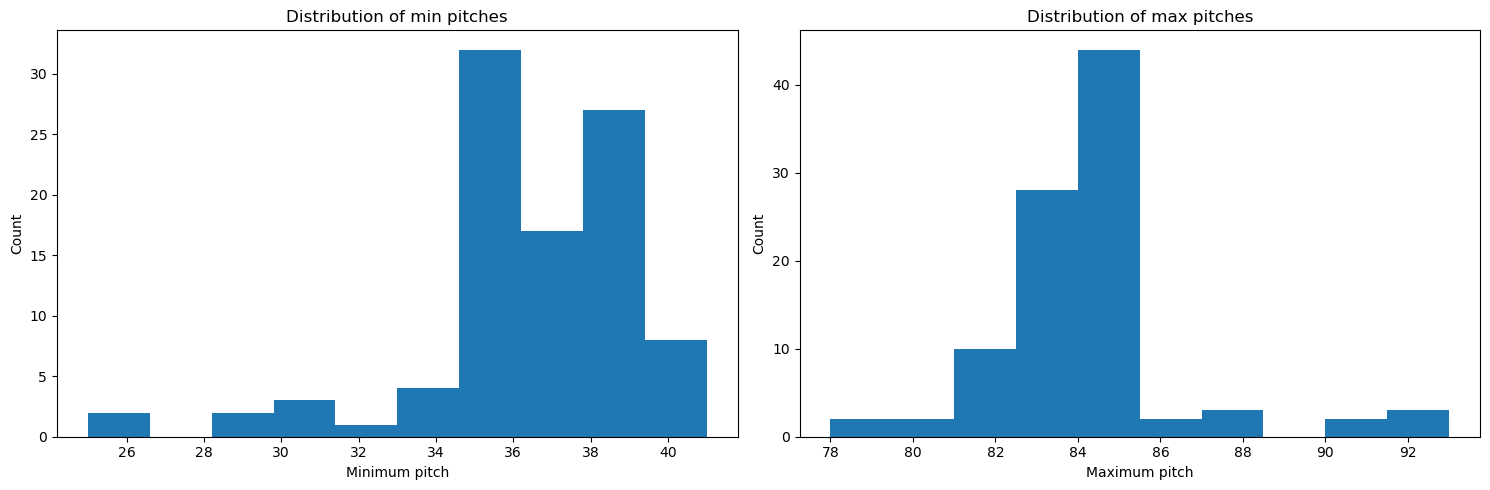

Minimum track pitch: 25
Maximum track pitch: 93


In [7]:
tracks_extreme_pitches = dict()

for name, track in datafilterd.items():
    tracks_extreme_pitches[name] = get_track_extreme_pitch({"" : track})[""] #trick because function for multi instruments.

_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist([elem[0] for elem in tracks_extreme_pitches.values()], bins=10)
axes[0].set_title("Distribution of min pitches")
axes[0].set_xlabel("Minimum pitch")
axes[0].set_ylabel("Count")
axes[1].hist([elem[1] for elem in tracks_extreme_pitches.values()], bins=10)
axes[1].set_title("Distribution of max pitches")
axes[1].set_xlabel("Maximum pitch")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Minimum track pitch: {min([elem[0] for elem in tracks_extreme_pitches.values()])}")
print(f"Maximum track pitch: {max([elem[1] for elem in tracks_extreme_pitches.values()])}")

Presence of extreme values and outliers to look at.

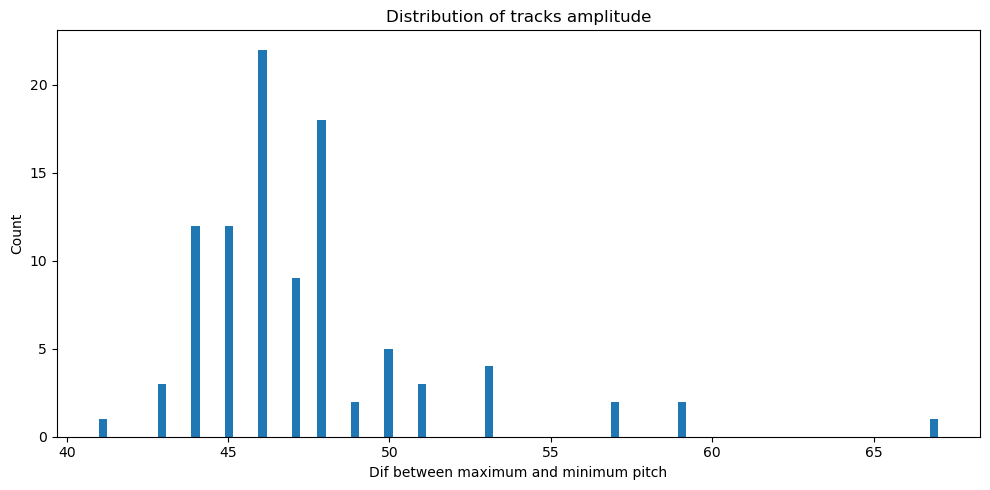

Maximum track amplitude: 67


In [8]:
tracks_amplitude = {name : pitches[1] - pitches[0] for name, pitches in tracks_extreme_pitches.items()}

plt.figure(figsize=(10,5))
plt.hist(tracks_amplitude.values(), bins=100)
plt.title(f"Distribution of tracks amplitude")
plt.xlabel("Dif between maximum and minimum pitch")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Maximum track amplitude: {max(tracks_amplitude.values())}")

We can remove at least the last data to reduce our network speed by at least 10% for the Convolution

In [9]:
big_amplitudes = sorted(tracks_amplitude, key=tracks_amplitude.get)[-5:]

print(big_amplitudes)

tracks_to_remove.append(big_amplitudes[-1])

print(f"New maximum track amplitude: {max([elem for name, elem in tracks_amplitude.items() if name not in tracks_to_remove])}")

['op87_16b', 'op87_11b', 'op87_18b', 'op87_02b', 'op87_15b']
New maximum track amplitude: 59


## Quantization check

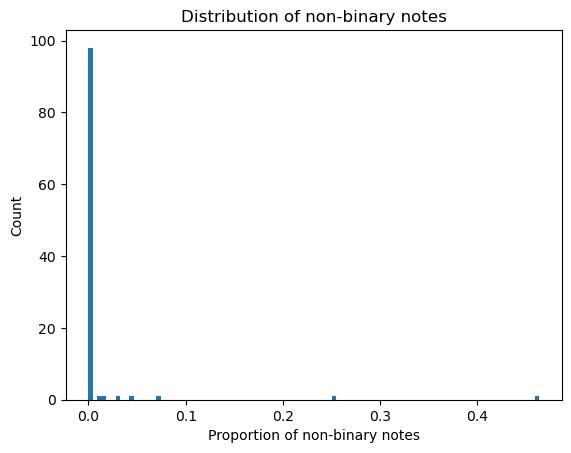

In [10]:
tracks_nbr_non_binary = dict()

for name, track in data.items():
    tracks_nbr_non_binary[name] = non_binary_notes({"" : track})

plt.hist(tracks_nbr_non_binary.values(), bins=100)
plt.title("Distribution of non-binary notes")
plt.xlabel("Proportion of non-binary notes")
plt.ylabel("Count")
plt.show()

Looking at 48 quantization, seems we do not have problem as the outliers are actually ternary.

In [11]:
non_binary_tracks_list = list()
for key, value in tracks_nbr_non_binary.items():
    if value > 0: non_binary_tracks_list.append((key, value))

non_binary_tracks_list.sort()
for elem in non_binary_tracks_list:
    print(elem)

('BWV_0850', 0.02802547770700637)
('BWV_0875', 0.2549019607843137)
('BWV_0879', 0.46368715083798884)
('BWV_0898', 0.013734812466983624)
('BWV_0944', 0.0005758710048949035)
('BWV_0951', 0.0006983240223463687)
('BWV_0959', 0.014492753623188406)
('BWV_0960', 0.0013917884481558804)
('BWV_0961', 0.04276315789473684)
('op87_16b', 0.0698356807511737)


op87 was solved using manual suppression of tempo changes. This does not work for BWV, so there is 2 types of tempo changes indicates by musescore : actual annotation and good approximation of their algorithm when changing. Tempo changes in BWV does not impact quantization.

Open midi with midi may let the file appear more inexact that they really are

With manual check:
- 875 and 879 are actually ternary
- 898 is okish, just the end of the track may not be that good
- op87_16b: better to let it as mido do or to remove it

## Some filtering

In [ ]:
data8 = load_pickle_data(os.path.join("Fugues_data", "data_8.pkl"))

for key in tracks_to_remove:
    try:
        del data8[key]
    except Exception as e:
        print(e)

save_dict(data8, os.path.join("Fugues_data", "data_8_reduced.pkl"))

In [13]:
tracks_to_remove

['op87_04b',
 'op87_10b',
 'op87_20b',
 'op87_23b',
 'BWV_0891',
 'op87_12b',
 'BWV_0944',
 'op87_21b',
 'op87_24b',
 'op87_15b']